In [351]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
import collections


In [352]:
def getGraphFromFile():
    graph = nx.read_edgelist('graph.txt', nodetype=int,
    data=(('weight',int),), create_using=nx.Graph())
    return graph

{(0, 1): Text(-0.557877917734078, 0.04565012662699787, '5'),
 (0, 2): Text(-0.519222775967154, -0.14279952432829568, '1'),
 (1, 2): Text(-0.25639254537984973, -0.14924931612472256, '7'),
 (1, 3): Text(0.019222775967153966, 0.0437441076558503, '4'),
 (2, 3): Text(0.05787791773407795, -0.14470554329944327, '2'),
 (3, 4): Text(0.6667466195405408, 0.12319935691301012, '3')}

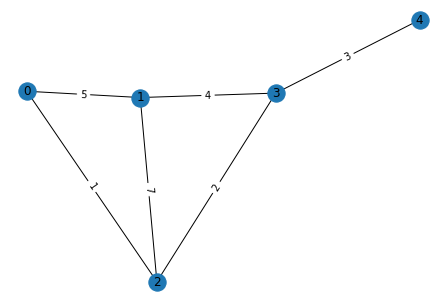

In [353]:
graph = getGraphFromFile()
pos = nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [354]:
qubitsNumber = graph.number_of_nodes()
layersNumber = 1
shotsNumber = 1000
device = qml.device("default.qubit", wires=qubitsNumber, shots=shotsNumber)

In [355]:
def U_b(beta):
    for qubit in range(qubitsNumber):
        qml.RX(2*beta, wires=qubit)

In [356]:
def U_c(gamma):
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        qml.CNOT(wires=[i,j])
        qml.RZ(weight*gamma, wires = j)
        qml.CNOT(wires=[i,j])

In [357]:
def compBasisMeasurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [358]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)

@qml.qnode(device)
def circuit(gammas, betas, edge=None):

    for i in range(0,qubitsNumber):
        qml.Hadamard(wires=i)

    for i in range(0,layersNumber):
        U_c(gammas[i])
        U_b(betas[i])

    if edge is None:
        return qml.sample(compBasisMeasurement(range(qubitsNumber)))

    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [359]:
def costFunction(params):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        cost -= 0.5*weight*(1-circuit(gammas, betas, edge=[i,j]))
    return cost

In [360]:
def getMaxCutSolution(params):
    gammas = params[0]
    betas = params[1]
    outputDecimal = circuit(gammas, betas)
    occurrences = collections.Counter(outputDecimal)
    return occurrences

In [361]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [362]:
if __name__ == '__main__':
    params = 0.01*np.random.rand(2, layersNumber)
    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.3)
    stepNumber = 200
    for i in range(stepNumber):
        params = optimizer.step(costFunction, params)
    print("Final results: " + str(getMaxCutSolution(params)))

Final results: Counter({22.0: 179, 9.0: 154, 14.0: 54, 29.0: 49, 2.0: 46, 8.0: 40, 23.0: 39, 6.0: 39, 17.0: 39, 1.0: 36, 20.0: 36, 25.0: 35, 19.0: 32, 30.0: 31, 11.0: 28, 21.0: 20, 4.0: 19, 12.0: 19, 10.0: 17, 15.0: 15, 27.0: 14, 16.0: 11, 18.0: 11, 24.0: 10, 13.0: 7, 26.0: 6, 7.0: 4, 5.0: 3, 28.0: 3, 3.0: 2, 31.0: 2})


In [363]:
    drawer = qml.draw(circuit)
    print(drawer(params[0],params[1]))

 0: ──H──╭C────────────╭C──╭C─────────────╭C───RX(-0.958)────────────────────────────────────────────────────────────────────────────────────────────────────╭┤ Sample[H0] 
 1: ──H──╰X──RZ(2.03)──╰X──│──────────────│───╭C─────────────────────╭C──╭C────────────╭C───RX(-0.958)───────────────────────────────────────────────────────├┤ Sample[H0] 
 2: ──H────────────────────╰X──RZ(0.405)──╰X──╰X───────────RZ(2.84)──╰X──│─────────────│───╭C─────────────────────╭C───RX(-0.958)────────────────────────────├┤ Sample[H0] 
 3: ──H──────────────────────────────────────────────────────────────────╰X──RZ(1.62)──╰X──╰X───────────RZ(0.81)──╰X──╭C─────────────────────╭C──RX(-0.958)──├┤ Sample[H0] 
 4: ──H───────────────────────────────────────────────────────────────────────────────────────────────────────────────╰X───────────RZ(1.22)──╰X──RX(-0.958)──╰┤ Sample[H0] 
H0 =
[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0 